# DAT-535 Final Project - Flight Delay Estimator
A well-known quote in data science is that data is something that has happened in the past, and in this project we will use this data to predict the future. The data in question can be found in ```data/flights_unstructured.txt``` and consists of flight times. In this project, based on when a number of planes from 2015 to 2024 were supposed to leave, actually left, we will estimate the expected delay. The project consists of 4 steps;

1. Spark Session Initialization

2. Data Ingestion

3. Data Cleaning

4. Data Serving

### Step 1: Spark Sesssion Initialization

#### 1.1 - Create a dynamic function for creating a Spark Session with different configuraiton

In [1]:
import findspark
findspark.init()

# import spark session
from pyspark.sql import SparkSession

# create spark session
# executor_memory, executor_instances, executor_cores beein dynamic
def create_spark_session(app_name, executor_memory, executor_instances, executor_cores):
    spark = SparkSession.builder.appName(app_name) \
        .config("spark.jars.packages", "io.delta:delta-core_2.12:2.1.0") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.master","yarn") \
        .config("spark.executor.memory", executor_memory) \
        .config("spark.driver.memory", "1g") \
        .config("spark.executor.instances", executor_instances) \
        .config("spark.dynamicAllocation.enabled", "false") \
        .config("spark.driver.memoryOverhead", "512m") \
        .config("spark.executor.memoryOverhead", "1g") \
        .config("spark.executor.cores",executor_cores) \
        .getOrCreate()
    return spark

#### After initializing the Spark session, download necessary libraries

In [2]:
import os
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pyspark
print(pyspark.__version__)
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lag, when
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
import numpy as np
from pyspark.sql.functions import lead

3.5.3


### 1.2 implement tests with different distributions of resources
#### Test_2:

In [ ]:
# works
spark = create_spark_session(
    app_name="Test_2",
    executor_memory="3g",
    executor_cores="3",
    executor_instances="4"
)

#### Test_3 (this is the test used to print the results in these notebook):

In [3]:
# works
spark = create_spark_session(
    app_name="Test_3",
    executor_memory="3g",
    executor_cores="4",
    executor_instances="3"
)

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d50e48c2-3c6b-420b-bdca-5a5418366207;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.1.0 in central
	found io.delta#delta-storage;2.1.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 134ms :: artifacts dl 5ms
	:: modules in use:
	io.delta#delta-core_2.12;2.1.0 from central in [default]
	io.delta#delta-storage;2.1.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evi

In [4]:
# Load data paths
data_path = "hdfs:///user/ubuntu/flights_unstructured.txt"
cleaned_data_path = "hdfs:///user/ubuntu/cleaned_flights_data.csv"

### Step 2: Data Cleaning

#### 2.1 Identify cleaning steps

We need to remove rows with empty cells, duplicate rows or rows with delay above 1999. We wanted to remove the rows containing high delay due to the anomalies could influence the models performance negatively.

We also want to remove rows where **CANCELLED** = 1. And check if the flight has a tail_number.

Finally we replace NaN with 0, so we can use these values when developing models. Then we remove duplicates with ```distinct()``` and save as one file with ```coalesce(1)```

####  2.2 Data Cleaning

In [6]:
os.system("hadoop fs -rm -r /user/ubuntu/cleaned_flights_data.csv/")

header = "YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY"

try:
    input_file = spark.sparkContext.textFile(data_path)

    def process_line(line):
        fields = line.strip().split(" ")

        if len(fields) < 31:
            fields += ['0'] * (31 - len(fields))
        
        if fields[24] and fields[24] == '1':
            return ('cancelled', line)
        
        if fields[6] == "":
            return ('missing_tail', line)
            
        try:
            if fields[11] and float(fields[11]) > 1999:
                return ('high_delay', line)
        except ValueError:
            return ('invalid_delay_format', line)
        
        fields = [f if f != "" else '0' for f in fields]

        return ('valid', ",".join(fields))

    categorized_data = input_file.map(process_line)
        
    cleaned_data = categorized_data \
        .filter(lambda x: x[0] == 'valid') \
        .map(lambda x: x[1]) \
        .distinct() \
        .coalesce(1) 

    final_data = spark.sparkContext.parallelize([header], 1).union(cleaned_data)

    final_data.coalesce(1).saveAsTextFile(cleaned_data_path)
    

except Exception as e:
    print(f"Error processing data: {e}")

rm: `/user/ubuntu/cleaned_flights_data.csv/': No such file or directory


#### 2.3 Read the new cleaned file

In [7]:
flights_df = spark.read.csv(cleaned_data_path, header=True)
flights_df.show(35)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

#### 2.4 Save instances where Airline is WN to WN_flights

In [8]:
WN_flights = flights_df.filter(flights_df.AIRLINE == "WN")

WN_flights.show(10)


+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

### Step 3: Data Serving

#### 3.1 Identify relevant business use case
For this data set, a relevant use case could be to estimate future delay based on the airline. This is also the use case on which our project is based.

#### 3.2 Identify relevant algorithms
Algorithms are the base of the models we will create
1. Linear Regression
2. Multivariable Linear Regression
3. Random Forest Regression
4. Multilinear Perceptron Classifier

##### 3.2.1 Creating common functions

In [ ]:
print(WN_flights.printSchema())

In [9]:
def create_types_MLR(WN_flights):
    print(WN_flights.columns)
    WN_flights = WN_flights.select(
        col("YEAR").cast("int"),
        col("MONTH").cast("int"),
        col("DAY").cast("int"),
        col("DAY_OF_WEEK").cast("int"),
        col("SCHEDULED_DEPARTURE").cast("float"),
        col("DEPARTURE_TIME").cast("float"),
        col("DEPARTURE_DELAY").cast("float"),
        col("TAXI_OUT").cast("float"),
        col("WHEELS_OFF").cast("float"),
        col("SCHEDULED_TIME").cast("float"),
        col("ELAPSED_TIME").cast("float"),
        col("AIR_TIME").cast("float"),
        col("DISTANCE").cast("float"),
        col("WHEELS_ON").cast("float"),
        col("TAXI_IN").cast("float"),
        col("SCHEDULED_ARRIVAL").cast("float"),
        col("ARRIVAL_TIME").cast("float"),
        col("ARRIVAL_DELAY").cast("float"),
        col("DIVERTED").cast("int"),
        col("CANCELLED").cast("int"),
        col("AIR_SYSTEM_DELAY").cast("float"),
        col("SECURITY_DELAY").cast("float"),
        col("AIRLINE_DELAY").cast("float"),
        col("LATE_AIRCRAFT_DELAY").cast("float"),
        col("WEATHER_DELAY").cast("float")
    )
    return WN_flights

def create_types_LR(WN_flights, use_lead):
    if use_lead:
        WN_flights = WN_flights.select(
            col("YEAR").cast("int"),
            col("MONTH").cast("int"),
            col("DAY").cast("int"),
            col("DAY_OF_WEEK").cast("int"),
            col("SCHEDULED_DEPARTURE").cast("float"),
            col("SCHEDULED_ARRIVAL").cast("float"),
            col("DEPARTURE_TIME").cast("float"),
            col("DEPARTURE_DELAY").cast("float"),
            col("DEPARTURE_DELAY_NEXT").cast("float")
        )
    else:
        WN_flights = WN_flights.select(
            col("YEAR").cast("int"),
            col("MONTH").cast("int"),
            col("DAY").cast("int"),
            col("DAY_OF_WEEK").cast("int"),
            col("SCHEDULED_DEPARTURE").cast("float"),
            col("SCHEDULED_ARRIVAL").cast("float"),
            col("DEPARTURE_TIME").cast("float"),
            col("DEPARTURE_DELAY").cast("float")
        )
    print(WN_flights.printSchema())
    return WN_flights


In [10]:
def create_assembler(use_lead, feature, WN_flights):  
    window_spec = Window.orderBy("YEAR", "MONTH", "DAY","DAY_OF_WEEK", "SCHEDULED_DEPARTURE")
    if use_lead:
        WN_flights = WN_flights.withColumn(feature, lag("DEPARTURE_DELAY",1).over(window_spec))
        WN_flights = WN_flights.filter(WN_flights[feature].isNotNull())
    WN_flights = create_types_LR(WN_flights, use_lead)

    assembler = VectorAssembler(inputCols=[feature], outputCol="features")
    data = assembler.transform(WN_flights)
    return data

In [11]:
def create_predictions(data, feature):
    train, test = data.randomSplit([0.8, 0.2], seed=12345)

    algo = LinearRegression(featuresCol="features", labelCol="DEPARTURE_DELAY")

    model = algo.fit(train)

    predictions = model.transform(test)

    RMSE = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="rmse").evaluate(predictions)
    R2 = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="r2").evaluate(predictions)
    return RMSE, R2, predictions

In [12]:
def plot_predictions(predictions, actual_col, pred_col, plot_title, figsize=(10, 6)):

    results = predictions.select(actual_col, pred_col).toPandas()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.plot(results[actual_col], label="Actual Values", color="red")
    
    ax.plot(results[pred_col], label="Predicted Values", color="blue")
    
    ax.set_xlabel("Index")
    ax.set_ylabel(actual_col)
    ax.set_xlim(0, 1000)
    ax.set_title(f"{plot_title}: Predicted vs Actual {actual_col}")
    ax.legend()
    
    return fig

##### 3.2.2 Implementing Linear Regression

In [14]:
for i in ["DEPARTURE_DELAY_NEXT", "SCHEDULED_ARRIVAL", "SCHEDULED_DEPARTURE"]:
    use_lead = False
    if i == "DEPARTURE_DELAY_NEXT":
        use_lead = True
    data = create_assembler(use_lead, i, WN_flights)
    data.show(3)
    RMSE,R2,predictions = create_predictions(data, i)
    print(f"{i} - RMSE: {RMSE}")
    print(f"{i} - R2: {R2}")

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- SCHEDULED_DEPARTURE: float (nullable = true)
 |-- SCHEDULED_ARRIVAL: float (nullable = true)
 |-- DEPARTURE_TIME: float (nullable = true)
 |-- DEPARTURE_DELAY: float (nullable = true)
 |-- DEPARTURE_DELAY_NEXT: float (nullable = true)

None


+----+-----+---+-----------+-------------------+-----------------+--------------+---------------+--------------------+--------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|SCHEDULED_DEPARTURE|SCHEDULED_ARRIVAL|DEPARTURE_TIME|DEPARTURE_DELAY|DEPARTURE_DELAY_NEXT|features|
+----+-----+---+-----------+-------------------+-----------------+--------------+---------------+--------------------+--------+
|2015|    1|  1|          4|              600.0|            745.0|         556.0|           -4.0|                -2.0|  [-2.0]|
|2015|    1|  1|          4|              600.0|            900.0|         607.0|            7.0|                -4.0|  [-4.0]|
|2015|    1|  1|          4|              600.0|            850.0|         559.0|           -1.0|                 7.0|   [7.0]|
+----+-----+---+-----------+-------------------+-----------------+--------------+---------------+--------------------+--------+
only showing top 3 rows



DEPARTURE_DELAY_NEXT - RMSE: 30.58478982389309
DEPARTURE_DELAY_NEXT - R2: 0.015206084946832621
root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- SCHEDULED_DEPARTURE: float (nullable = true)
 |-- SCHEDULED_ARRIVAL: float (nullable = true)
 |-- DEPARTURE_TIME: float (nullable = true)
 |-- DEPARTURE_DELAY: float (nullable = true)

None
+----+-----+---+-----------+-------------------+-----------------+--------------+---------------+--------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|SCHEDULED_DEPARTURE|SCHEDULED_ARRIVAL|DEPARTURE_TIME|DEPARTURE_DELAY|features|
+----+-----+---+-----------+-------------------+-----------------+--------------+---------------+--------+
|2015|    6|  2|          2|             2010.0|           2130.0|        2012.0|            2.0|[2130.0]|
|2015|    6|  2|          2|             2010.0|           2300.0|        2100.0|           50.0|[2300.0]|
|2015|    6|  2

SCHEDULED_ARRIVAL - RMSE: 30.23771850324209
SCHEDULED_ARRIVAL - R2: 0.028014371836947105
root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- SCHEDULED_DEPARTURE: float (nullable = true)
 |-- SCHEDULED_ARRIVAL: float (nullable = true)
 |-- DEPARTURE_TIME: float (nullable = true)
 |-- DEPARTURE_DELAY: float (nullable = true)

None
+----+-----+---+-----------+-------------------+-----------------+--------------+---------------+--------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|SCHEDULED_DEPARTURE|SCHEDULED_ARRIVAL|DEPARTURE_TIME|DEPARTURE_DELAY|features|
+----+-----+---+-----------+-------------------+-----------------+--------------+---------------+--------+
|2015|    6|  2|          2|             2010.0|           2130.0|        2012.0|            2.0|[2010.0]|
|2015|    6|  2|          2|             2010.0|           2300.0|        2100.0|           50.0|[2010.0]|
|2015|    6|  2|     

SCHEDULED_DEPARTURE - RMSE: 29.98982889192092
SCHEDULED_DEPARTURE - R2: 0.043885774453167437


##### 3.2.3 Multivariable Linear Regression

In [15]:
# read WN again so that we can use it for the MLR model
WN_flights = flights_df.filter(flights_df.AIRLINE == "WN")

# declare schema
WN_flights = create_types_MLR(WN_flights)

window_spec = Window.orderBy("YEAR", "MONTH", "DAY","DAY_OF_WEEK", "SCHEDULED_DEPARTURE")

# create features
feature_columns = [
        "YEAR", "MONTH", "DAY", "DAY_OF_WEEK", "SCHEDULED_DEPARTURE", "DEPARTURE_TIME",
        "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_TIME", 
        "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "WHEELS_ON", "TAXI_IN", 
        "SCHEDULED_ARRIVAL", "ARRIVAL_TIME", "ARRIVAL_DELAY", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", 
        "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
    ]

# create new column with the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(WN_flights)

# scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaled_data = scaler.fit(data).transform(data)

# save the scaled features
assembler = VectorAssembler(inputCols = feature_columns, outputCol="features")
data = assembler.transform(WN_flights)

# train the model
train, test = data.randomSplit([0.8, 0.2], seed=12345)

# pick the algorithm
algo = LinearRegression(featuresCol="features", labelCol="DEPARTURE_DELAY")

# make predictions
model = algo.fit(train)
predictions = model.transform(test)

# create evaluation metrics
RMSE = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="rmse").evaluate(predictions)
R2 = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="r2").evaluate(predictions)

['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


Print evaluation metrics

In [16]:
print(f"RMSE: {RMSE}")
print(f"R2: {R2}")

RMSE: 4.62239523080943
R2: 0.9776351403113589


In [17]:
coefficients = model.coefficients
intercept = model.intercept

print("Model Coefficients:")
for feature, weight in zip(feature_columns, coefficients):
    print(f"{feature}: {weight:.4f}")

print(f"Intercept: {intercept:.4f}")

Model Coefficients:
YEAR: 0.0000
MONTH: 0.0127
DAY: 0.0024
DAY_OF_WEEK: 0.0046
SCHEDULED_DEPARTURE: -0.0033
DEPARTURE_TIME: 0.0040
TAXI_OUT: -2.5125
WHEELS_OFF: -0.0001
SCHEDULED_TIME: 0.7142
ELAPSED_TIME: 1.6839
AIR_TIME: -2.3354
DISTANCE: -0.0067
WHEELS_ON: -0.0004
TAXI_IN: -2.4876
SCHEDULED_ARRIVAL: 0.0006
ARRIVAL_TIME: -0.0004
ARRIVAL_DELAY: 0.8188
AIR_SYSTEM_DELAY: 0.0565
SECURITY_DELAY: 0.1962
AIRLINE_DELAY: 0.1804
LATE_AIRCRAFT_DELAY: 0.1829
WEATHER_DELAY: 0.1692
Intercept: 0.4397


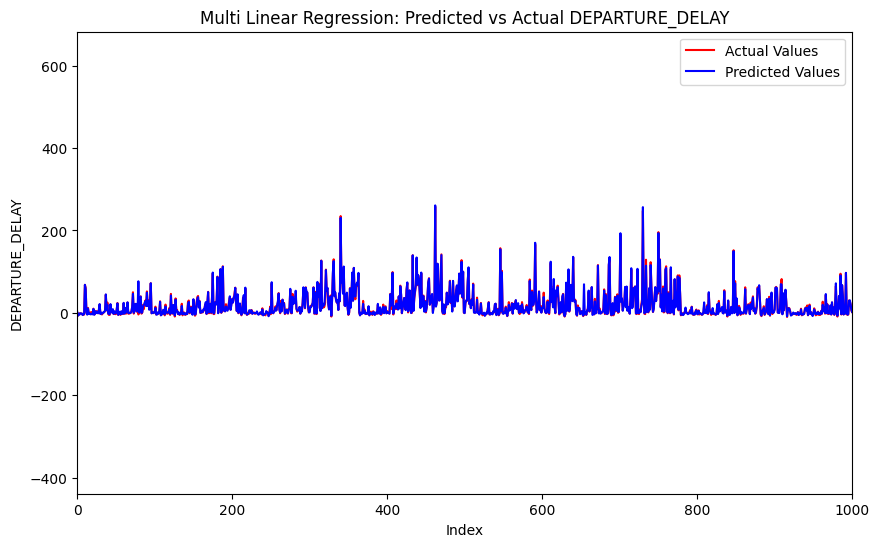

In [19]:
fig = plot_predictions(predictions, actual_col="DEPARTURE_DELAY", pred_col="prediction", plot_title = "Multi Linear Regression")

plt.show()

**Comment:**<br>
This model is far better than simple LR, which probably is caused by the fact that *scheduled_departure* and *departure_time* is included as features. Which means the model could compare these and calculate the *departure_delay*. The model does however predict *departure_delays* at values supasing $-200$ minutes, which does not really make sense. No *departure_delay* values in the original dataset goes beyond $-90$.

##### 3.2.4 Random Forest Regression

In [20]:
# initialize the RF model, set num of trees to 50 and seed value to 12345
rf = RandomForestRegressor(featuresCol="features", labelCol="DEPARTURE_DELAY", numTrees=50, seed=12345)
rf_model = rf.fit(train)

# make predictions
predictions = rf_model.transform(test)

# create evaluation metrics
rmse = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="rmse").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="r2").evaluate(predictions)

# print
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 12.44832536300776
R2: 0.8377988656873592


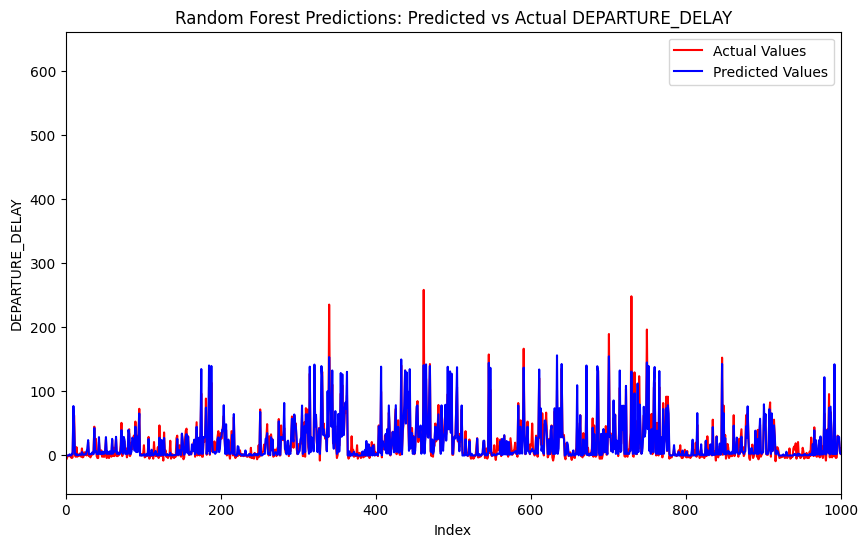

In [21]:
fig = plot_predictions(predictions, actual_col="DEPARTURE_DELAY", pred_col="prediction", plot_title = "Random Forest Predictions")

plt.show()

# Deep Learning Model

##### 3.2.5 Multilayer Perceptron for Regression

In [22]:
# create a bucketizer to convert the DEPARTURE_DELAY column into a categorical label
splits = float('-inf'), -15, -5, 5, 15, 30, float('inf')
bucketizer = Bucketizer(
    splits=splits,
    inputCol="DEPARTURE_DELAY",
    outputCol="label"
)

data_with_labels = bucketizer.transform(data)

# create the scaler and classifier
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# define node in hidden layers
input_size = len(feature_columns)
hidden_layer1 = 32
hidden_layer2 = 16
hidden_layer3 = 8
output_size = 6

layers = [input_size, hidden_layer1, hidden_layer2, hidden_layer3, output_size]

# create the classifier
classifier = MultilayerPerceptronClassifier(
    featuresCol="scaledFeatures",
    labelCol="label",
    layers=layers,
    blockSize=64,
    seed=12345,
    maxIter=100,
    stepSize=0.03   
)

# create the pipeline
pipeline = Pipeline(stages=[scaler, classifier])

train, test = data_with_labels.randomSplit([0.8, 0.2], seed=12345)

# train the model
model = pipeline.fit(train)

# make predictions
predictions = model.transform(test)

# create the evaluator, calculate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

# convert the predictions back to numeric values
predictions = predictions.withColumn(
    "numeric_prediction",
    when(col("prediction") == 0, -20)  
    .when(col("prediction") == 1, -10) 
    .when(col("prediction") == 2, 0)    
    .when(col("prediction") == 3, 10)   
    .when(col("prediction") == 4, 22.5) 
    .when(col("prediction") == 5, 45)   
)

rmse = RegressionEvaluator(
    labelCol="DEPARTURE_DELAY",
    predictionCol="numeric_prediction",
    metricName="rmse"
).evaluate(predictions)

r2 = RegressionEvaluator(
    labelCol="DEPARTURE_DELAY",
    predictionCol="numeric_prediction",
    metricName="r2"
).evaluate(predictions)


print("\nModel Performance Metrics:")
print(f"Classification Accuracy: {accuracy:.4f}")
print(f"RMSE (after conversion): {rmse:.2f}")
print(f"R2 (after conversion): {r2:.2f}")


Model Performance Metrics:
Classification Accuracy: 0.9642
RMSE (after conversion): 21.46
R2 (after conversion): 0.52


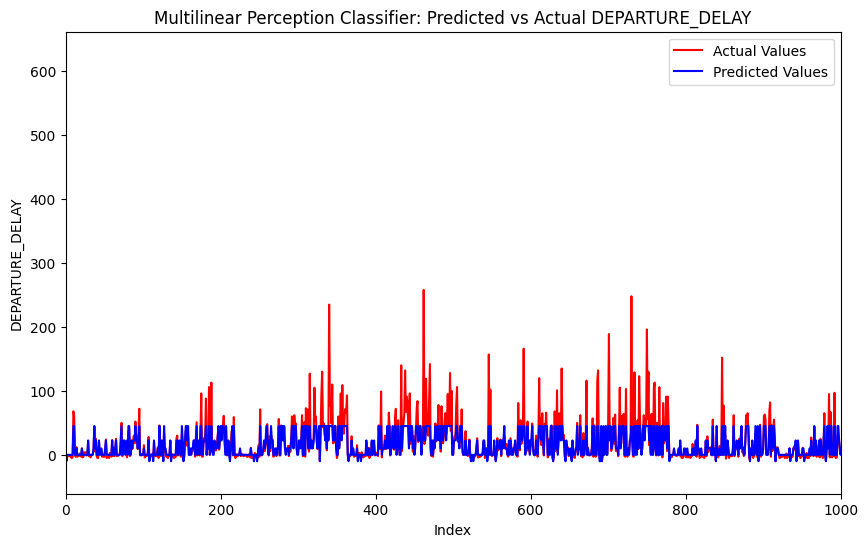

In [23]:
fig = plot_predictions(predictions, actual_col="DEPARTURE_DELAY", pred_col="numeric_prediction", plot_title = "Multilinear Perception Classifier")

plt.show()